In [1]:
# set parameters
import pandas as pd
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'

METADATA = {'Contributor': 'T. Dunn'}

ALL_SOURCE_BOOKS = ['BR','PH','MM','HotDQ','RoT','DMG','PotA','OotA','SCAG','CoS','SKT','VGtM','TftYP','ToA','XGtE','MToF','WDH','WDotMM','GGtR','GoS','BGDiA','ERftLW','EGtW','MOoT','IDRotF','TCoE','CM','VRGtR','FToD']
ALL_RULES_BOOKS = ['BR','PH','MM','DMG','SCAG','VGtM','XGtE','MToF','GGtR','ERftLW','EGtW','MOoT','TCoE','VRGtR','FToD']
ALL_ADVENTURE_BOOKS = ['HotDQ','RoT','PotA','OotA','CoS','SKT','TftYP','ToA','WDH','WDotMM','GoS','BGDiA','IDRotF','CM']

In [2]:
# define functions

def find_nearest_loc(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def defensive_CR(df, HP, AC):
    n = df.shape[0]
    id = find_nearest_loc(df['HP Mean'], HP)
    CR_t = df.index[id]
    AC_t = df['AC'].loc[CR_t]
    id = int(max(0, min(n - 1, id + np.fix(0.5*(AC - AC_t)))))
    CR = df.index[id]
    return CR

def offensive_CR(df, DPR, AB):
    n = df.shape[0]
    id = find_nearest_loc(df['DPR Mean'], DPR)
    CR_t = df.index[id]
    AB_t = df['AB'].loc[CR_t]
    id = int(max(0, min(n - 1, id + np.fix(0.5*(AB - AB_t)))))
    CR = df.index[id]
    return CR

In [3]:
# import data
import pandas as pd
import numpy as np

dfD = pd.read_csv('dmg-targets-cr-and-xp.csv') # 'CR','PB','XP','AC','HP Mean','AB','DPR Mean'
dfD['eHP Mean']  = dfD['HP Mean' ]*np.power(1.05, dfD['AC'] - 12)
dfD['eDPR Mean'] = dfD['DPR Mean']*np.power(1.05, dfD['AB'] -  2)
dfD['eXP Mean'] = 0.25*dfD['eHP Mean']*dfD['eDPR Mean']
dfD.set_index('CR', inplace=True)


df0 = pd.read_csv('monster-cr-and-xp.csv')  # 'Book','Page','Type','Category','Legendary','CR','PB','XP',
                                            # 'HP','AC','adj HP','adj AC',
                                            # 'AB','adj AB','DPR', 'adj DPR'

df0['D-CR DMG'] = df0.apply(lambda row: defensive_CR(dfD, row['adj HP'], row['adj AC']), axis=1)
df0['O-CR DMG'] = df0.apply(lambda row: offensive_CR(dfD, row['adj DPR'], row['adj AB']), axis=1)
df0['C-CR DMG'] = 0.5*(df0['D-CR DMG'] + df0['O-CR DMG'])

df0['D-CR DMG Delta'] = df0['D-CR DMG'] - df0['CR']
df0['O-CR DMG Delta'] = df0['O-CR DMG'] - df0['CR']
df0['C-CR DMG Delta'] = df0['C-CR DMG'] - df0['CR']

df0['D-CR DMG unadj'] = df0.apply(lambda row: defensive_CR(dfD, row['HP'], row['AC']), axis=1)
df0['O-CR DMG unadj'] = df0.apply(lambda row: offensive_CR(dfD, row['DPR'], row['AB']), axis=1)
df0['C-CR DMG unadj'] = 0.5*(df0['D-CR DMG unadj'] + df0['O-CR DMG unadj'])

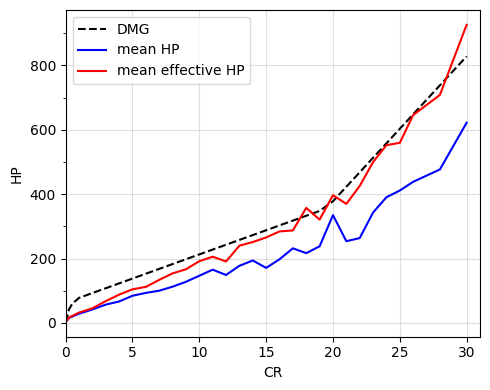

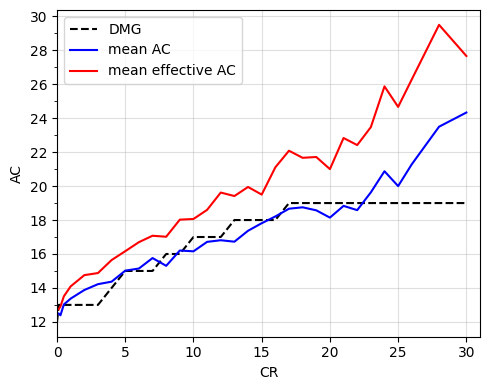

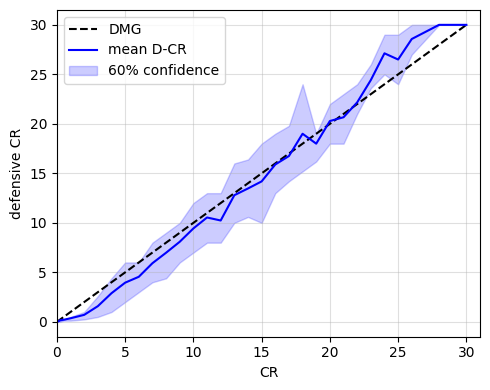

In [4]:
# AC, HP, D-CR
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.8)
dfL = df0.groupby('CR').quantile(0.2)

# hit points
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='HP')
ax.plot(dfD0.index, dfD0['HP Mean'], '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['HP'], '-', color='b', label='mean HP')
ax.plot(dfG.index, dfG['adj HP'], '-', color='r', label='mean effective HP')
ax.yaxis.set_major_locator(MultipleLocator(200))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(100))
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('hp-vs-cr.svg', metadata=METADATA)

# armor class
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='AC')
ax.plot(dfD0.index, dfD0['AC'], '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['AC'], '-', color='b', label='mean AC')
ax.plot(dfG.index, dfG['adj AC'], '-', color='r', label='mean effective AC')
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('ac-vs-cr.svg', metadata=METADATA)

# D-CR
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='defensive CR')
ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['D-CR DMG'], '-', color='b', label='mean D-CR')
ax.fill_between(dfG.index, dfL['D-CR DMG'], dfU['D-CR DMG'], alpha=0.2, color='b', label='60% confidence')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('d-cr-vs-cr.svg', metadata=METADATA)

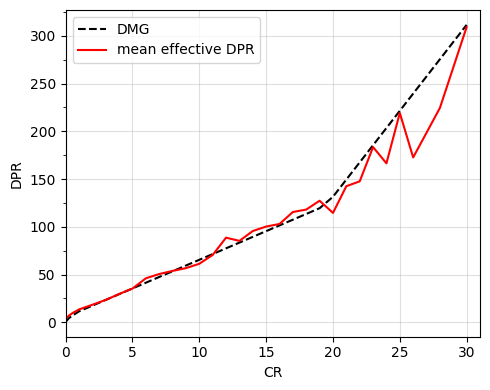

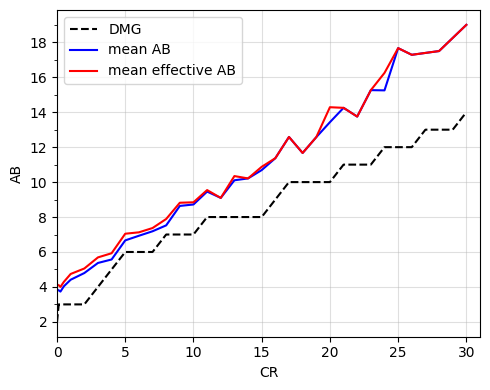

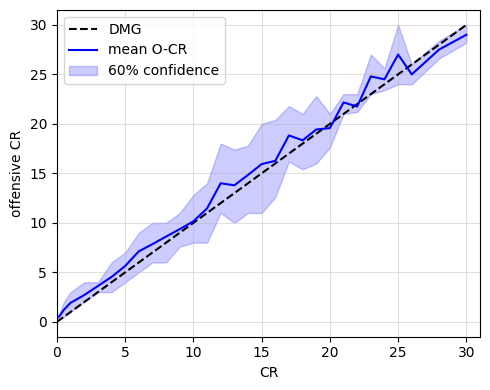

In [5]:
# DPR, AB, O-CR
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.8)
dfL = df0.groupby('CR').quantile(0.2)

# damage per round
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='DPR')
ax.plot(dfD0.index, dfD0['DPR Mean'], '--', color='k', label='DMG')
#ax.plot(dfG.index, dfG['DPR'], '-', color='b', label='mean DPR')
ax.plot(dfG.index, dfG['DPR'], '-', color='r', label='mean effective DPR')
ax.yaxis.set_major_locator(MultipleLocator(50))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(25))
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('dpr-vs-cr.svg', metadata=METADATA)

# attack bonus
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='AB')
ax.plot(dfD0.index, dfD0['AB'], '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['AB'], '-', color='b', label='mean AB')
ax.plot(dfG.index, dfG['adj AB'], '-', color='r', label='mean effective AB')
ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(1))
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('ab-vs-cr.svg', metadata=METADATA)

# O-CR
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel='offensive CR')
ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['O-CR DMG'], '-', color='b', label='mean O-CR')
ax.fill_between(dfG.index, dfL['O-CR DMG'], dfU['O-CR DMG'], alpha=0.2, color='b', label='60% confidence')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('o-cr-vs-cr.svg', metadata=METADATA)

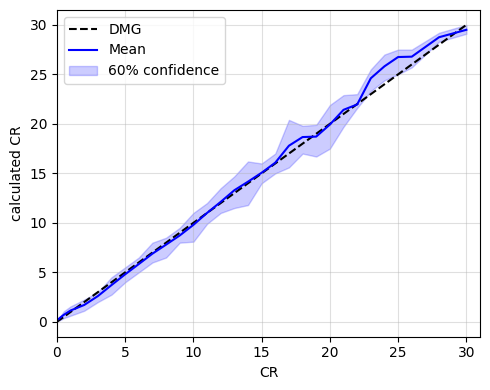

In [6]:
# DMG CR
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.8)
dfL = df0.groupby('CR').quantile(0.2)

# CR
col = 'C-CR DMG'
ylab = 'calculated CR'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel=ylab)
ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.plot(dfG.index, dfG[col], '-', color='b', label='Mean')
ax.fill_between(dfG.index, dfL[col], dfU[col], alpha=0.2, color='b', label='60% confidence')

ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

plt.savefig('dmg-cr-vs-cr.svg', metadata=METADATA)

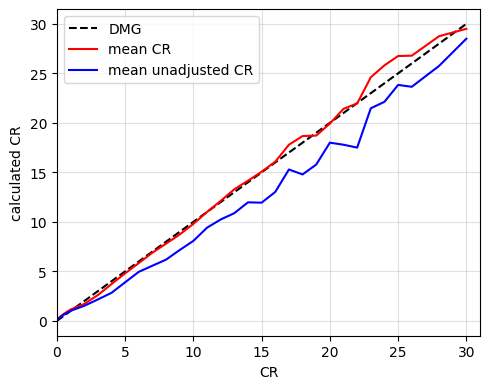

In [7]:
# DMG CR
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.8)
dfL = df0.groupby('CR').quantile(0.2)

# CR
ylab = 'calculated CR'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel=ylab)
ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.plot(dfG.index, dfG['C-CR DMG'], '-', color='r', label='mean CR')
ax.plot(dfG.index, dfG['C-CR DMG unadj'], '-', color='b', label='mean unadjusted CR')
#ax.fill_between(dfG.index, dfL[col], dfU[col], alpha=0.2, color='b', label='60% confidence')

ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

#plt.savefig('dmg-cr-vs-cr.svg', metadata=METADATA)

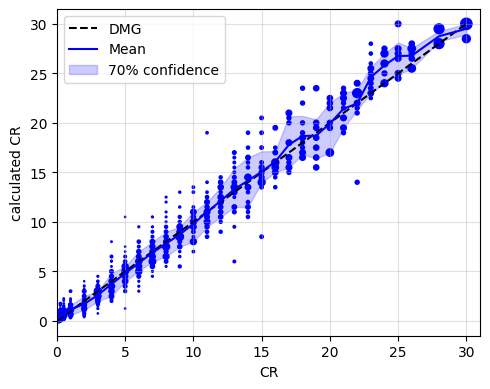

In [8]:
# DMG CR
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.85)
dfL = df0.groupby('CR').quantile(0.15)

# CR
col = 'C-CR DMG'
ylab = 'calculated CR'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel=ylab)
ax.grid(which='major', axis='both', alpha=0.4)

ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.fill_between(dfG.index, dfL[col], dfU[col], alpha=0.2, color='b', label='70% confidence')
ax.plot(dfG.index, dfG[col], '-', color='b', label='Mean')

dfC = df0.groupby(['CR']).size().to_frame('Count')
dft = df0.groupby(['CR', col]).size().to_frame('Count').reset_index()
for CR in dfC.index:
    n = dfC['Count'].loc[CR]
    mask = dft['CR'].isin([CR])
    dft.loc[mask, 'Count'] = 100*dft.loc[mask, 'Count']/n
ax.scatter('CR', col, s='Count', data=dft, alpha=1.0, color='b', label='')

ax.legend(loc='upper left')


#plt.savefig('dmg-cr-vs-cr.svg', metadata=METADATA)

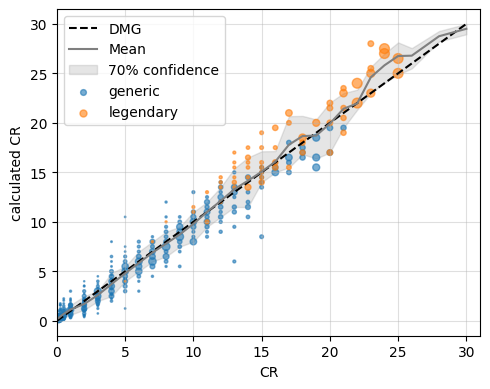

In [9]:
# DMG CR
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

dfD0 = dfD
dfG = df0.groupby('CR').mean()
dfU = df0.groupby('CR').quantile(0.85)
dfL = df0.groupby('CR').quantile(0.15)

# CR
col = 'C-CR DMG'
ylab = 'calculated CR'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], xlabel='CR', ylabel=ylab)
ax.grid(which='major', axis='both', alpha=0.4)

ax.plot(dfD0.index, dfD0.index, '--', color='k', label='DMG')
ax.fill_between(dfG.index, dfL[col], dfU[col], alpha=0.2, color='#7f7f7f', label='70% confidence')
ax.plot(dfG.index, dfG[col], '-', color='#7f7f7f', label='Mean')

#cats = ['generic','legendary','unique']
#colors = ['#1f77b4','#ff7f0e','#2ca02c']
cats = ['generic','legendary']
colors = ['#1f77b4','#ff7f0e']
dfC = df0[df0['Category'].isin(cats)].groupby(['CR']).size().to_frame('Count')
dft = df0.groupby(['CR', 'Category', col]).size().to_frame('Count').reset_index()
for CR in dfC.index:
    n = dfC['Count'].loc[CR]
    mask = dft['CR'].isin([CR])
    dft.loc[mask, 'Count'] = 100*dft.loc[mask, 'Count']/n
for cat, co in zip(cats, colors):
    ax.scatter('CR', col, s='Count', data=dft[dft['Category'].isin([cat])], alpha=0.6, color=co, label=cat)

ax.legend(loc='upper left')


#plt.savefig('dmg-cr-vs-cr.svg', metadata=METADATA)

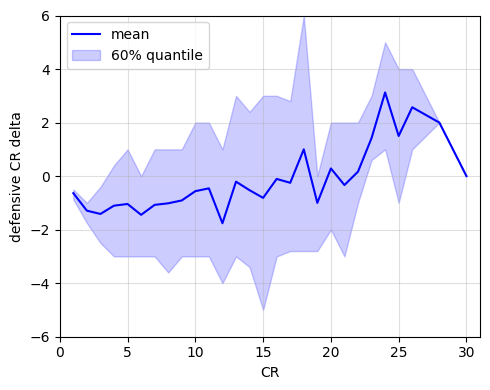

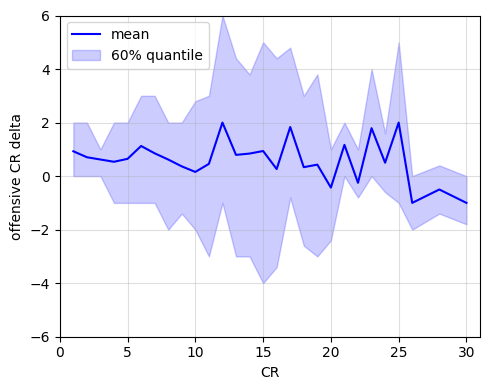

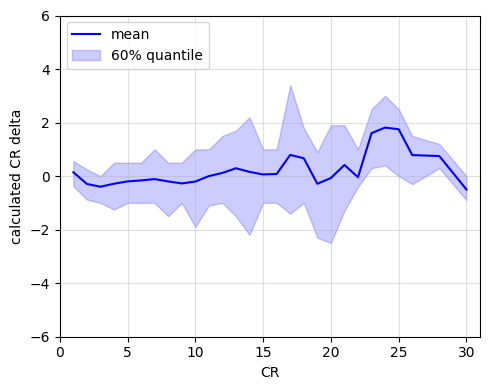

In [10]:
# DMG CR deltas
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

dfD0 = dfD
df1 = df0[df0['CR'].between(1,30) & df0['Category'].isin(['generic','legendary','unique'])]
dfG = df1.groupby('CR').mean()
dfU = df1.groupby('CR').quantile(0.8)
dfL = df1.groupby('CR').quantile(0.2)

# D-CR
col = 'D-CR DMG'
ylab = 'defensive CR delta'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], ylim=[-6,6], xlabel='CR', ylabel=ylab)
ax.plot(dfG.index, dfG[col] - dfG.index, '-', color='b', label='mean')
ax.fill_between(dfG.index, dfL[col] - dfG.index, dfU[col] - dfG.index, alpha=0.2, color='b', label='60% quantile')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

#plt.savefig('dmg-d-cr-delta-vs-cr.png')

# O-CR
col = 'O-CR DMG'
ylab = 'offensive CR delta'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], ylim=[-6,6], xlabel='CR', ylabel=ylab)
ax.plot(dfG.index, dfG[col] - dfG.index, '-', color='b', label='mean')
ax.fill_between(dfG.index, dfL[col] - dfG.index, dfU[col] - dfG.index, alpha=0.2, color='b', label='60% quantile')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

#plt.savefig('dmg-o-cr-delta-vs-cr.svg', metadata=METADATA)

# CR
col = 'C-CR DMG'
ylab = 'calculated CR delta'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], ylim=[-6,6], xlabel='CR', ylabel=ylab)
ax.plot(dfG.index, dfG[col] - dfG.index, '-', color='b', label='mean')
ax.fill_between(dfG.index, dfL[col] - dfG.index, dfU[col] - dfG.index, alpha=0.2, color='b', label='60% quantile')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

#plt.savefig('dmg-cr-delta-vs-cr.svg', metadata=METADATA)

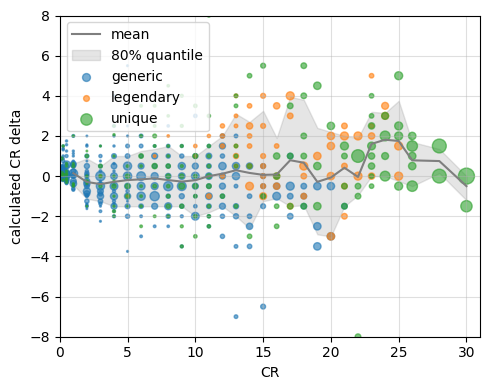

In [11]:
# DMG CR deltas
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

cats = ['generic','legendary','unique']
colors = ['#1f77b4','#ff7f0e','#2ca02c']
#cats = ['generic','legendary']
#colors = ['#1f77b4','#ff7f0e']

dfD0 = dfD
df1 = df0[df0['CR'].between(1,30) & df0['Category'].isin(cats)]
dfG = df1.groupby('CR').mean()
dfU = df1.groupby('CR').quantile(0.90, interpolation='linear')
dfL = df1.groupby('CR').quantile(0.10, interpolation='linear')

# CR
col = 'C-CR DMG Delta'
ylab = 'calculated CR delta'
fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0, 31], ylim=[-8,8], xlabel='CR', ylabel=ylab)
ax.grid(which='major', axis='both', alpha=0.4)

ax.plot(dfG.index, dfG[col], '-', color='#7f7f7f', label='mean')
ax.fill_between(dfG.index, dfL[col], dfU[col], alpha=0.2, color='#7f7f7f', label='80% quantile')

dfC = df0.groupby(['CR']).size().to_frame('Count')
dft = df0.groupby(['CR', 'Category', col]).size().to_frame('Count').reset_index()
for CR in dfC.index:
    n = dfC['Count'].loc[CR]
    mask = dft['CR'].isin([CR])
    dft.loc[mask, 'Count'] = 200*dft.loc[mask, 'Count']/n

for cat, co in zip(cats, colors):
    ax.scatter('CR', col, s='Count', data=dft[dft['Category'].isin([cat])], alpha=0.6, color=co, label=cat)

ax.legend(loc='upper left')

#plt.savefig('dmg-cr-delta-vs-cr.svg', metadata=METADATA)

In [12]:
# DMG CR deltas
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

cats = ['generic','legendary','unique']
colors = ['#1f77b4','#ff7f0e','#2ca02c']
#cats = ['generic','legendary']
#colors = ['#1f77b4','#ff7f0e']

dfD0 = dfD
df1 = df0[ (df0['C-CR DMG Delta'].between(-4,4) == False) & df0['CR'].between(1,30) & df0['Category'].isin(cats)]
df1

,Book,Page,Type,Category,Legendary,CR,PB,XP,HP,AC,...,adj DPR,D-CR DMG,O-CR DMG,C-CR DMG,D-CR DMG Delta,O-CR DMG Delta,C-CR DMG Delta,D-CR DMG unadj,O-CR DMG unadj,C-CR DMG unadj
687,BGDiA,237.0,celestial,generic,N,5.0,3,1800.0,36.0,18.0,...,34.00000,16.0,5.0,10.5,11.0,0.0,5.5,1.0,5.0,3.0
898,PotA,199.0,monstrosity,unique,LL,8.0,3,3900.0,136.0,15.0,...,47.00000,15.0,10.0,12.5,7.0,2.0,4.5,5.0,8.0,6.5
1024,RoT,92.0,humanoid,unique,L,11.0,4,7200.0,150.0,16.0,...,170.00000,19.0,19.0,19.0,8.0,8.0,8.0,6.0,19.0,12.5
1069,MM,257.0,fiend,generic,N,13.0,5,10000.0,110.5,16.0,...,18.00000,8.0,4.0,6.0,-5.0,-9.0,-7.0,4.0,4.0,4.0
1100,WDotMM,174.0,construct,unique,N,14.0,5,11500.0,310.0,20.0,...,176.00000,17.0,21.0,19.0,3.0,7.0,5.0,17.0,21.0,19.0
1102,MToF,162.0,fiend,generic,N,15.0,5,13000.0,187.5,18.0,...,29.50000,12.0,5.0,8.5,-3.0,-10.0,-6.5,9.0,5.0,7.0
1114,CoS,239.0,undead,unique,LL,15.0,5,13000.0,144.5,16.0,...,130.66667,21.0,20.0,20.5,6.0,5.0,5.5,5.0,20.0,12.5
1160,PotA,220.0,elemental,unique,LL,18.0,6,20000.0,283.5,22.0,...,141.00000,25.0,22.0,23.5,7.0,4.0,5.5,17.0,22.0,19.5
1164,PotA,214.0,elemental,unique,LL,19.0,6,22000.0,325.0,17.0,...,216.00000,22.0,25.0,23.5,3.0,6.0,4.5,16.0,25.0,20.5
1196,OotA,204.0,humanoid,unique,N,22.0,7,41000.0,132.0,19.0,...,75.00000,14.0,14.0,14.0,-8.0,-8.0,-8.0,7.0,14.0,10.5


In [13]:
# DMG CR deltas
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

column = 'Type'

df1 = df0[df0['CR'].between(1,30)]
dfG = df1.groupby(column).mean()

x = dfG.index.tolist()
x_pos = [i for i, _ in enumerate(x)]
y = dfG['CR Delta DMG'].to_list()



ax.barh(x_pos, y)

plt.yticks(x_pos, x)

ax.xaxis.set_major_locator(MultipleLocator(0.5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.xaxis.set_minor_locator(MultipleLocator(0.25))

#ax.grid(which='major', axis='both', alpha=0.4)

df1.groupby(column).std()['CR Delta DMG']




KeyError: 'CR Delta DMG'

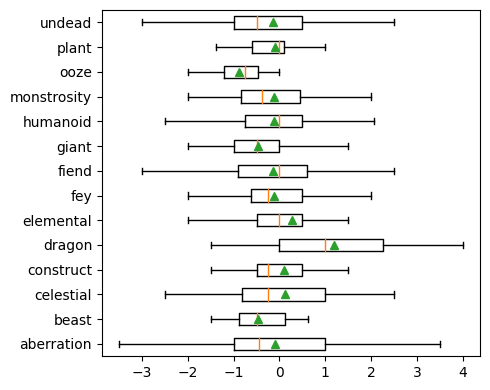

In [ ]:
df1 = df0[df0['CR'].between(1,30)]

col = 'Type'
groups = df1[col].sort_values().unique()

fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes()
bp = ax.boxplot(tuple(df1[df1[col].isin([g])]['C-CR DMG Delta'] for g in groups), 
    labels=groups, showmeans=True, vert=False, showfliers=False, patch_artist=False)


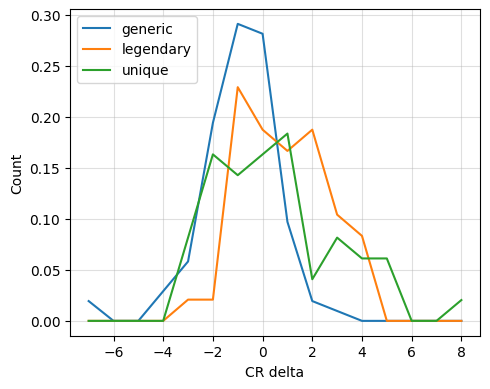

In [ ]:
# DMG CR deltas
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

df1 = df0[df0['CR'].between(10,20)]

rMin = df1['CR Delta DMG'].min()
rMax = df1['CR Delta DMG'].max()
rDel = 1.0
nBins = int(np.round(1 + (rMax - rMin)/rDel))
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)
x = np.linspace(rMin, rMax, nBins)

fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlabel='CR delta', ylabel='Count')
y, t = np.histogram(df1[df1['Category'].isin(['generic'])]['CR Delta DMG'], rRange, density=True); ax.plot(x, y, label='generic')
y, t = np.histogram(df1[df1['Category'].isin(['legendary'])]['CR Delta DMG'], rRange, density=True); ax.plot(x, y, label='legendary')
y, t = np.histogram(df1[df1['Category'].isin(['unique'])]['CR Delta DMG'], rRange, density=True); ax.plot(x, y, label='unique')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

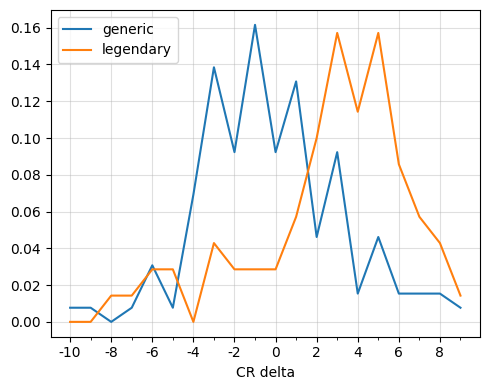

In [ ]:
# DMG CR deltas
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

df1 = df0[df0['CR'].between(10,20)]

column = 'O-CR Delta DMG'
rMin = df1[column].min()
rMax = df1[column].max()
rDel = 1.0
nBins = int(np.round(1 + (rMax - rMin)/rDel))
rRange = np.linspace(rMin - rDel/2, rMax + rDel/2, int(round((rMax - rMin)/rDel)) + 2)
x = np.linspace(rMin, rMax, nBins)

fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlabel='CR delta')
y, t = np.histogram(df1[df1['Legendary'].isin(['N'])][column], rRange, density=True); ax.plot(x, y, label='generic')
y, t = np.histogram(df1[df1['Legendary'].isin(['L','LL'])][column], rRange, density=True); ax.plot(x, y, label='legendary')
ax.legend(loc='upper left')
ax.grid(which='major', axis='both', alpha=0.4)

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

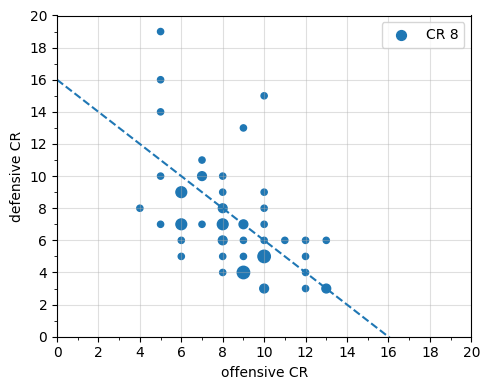

In [ ]:
# DPR vs HP
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRs = [8]
#colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = colors[0:3]

fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0,20], ylim=[0,20], xlabel='offensive CR', ylabel='defensive CR')

for CR, c in zip(CRs, colors):
    df1 = df0[df0['CR'].isin([CR]) & df0['Category'].isin(['generic','legendary','unique'])]
    dft = df1.groupby(['D-CR DMG', 'O-CR DMG']).size().to_frame('Count').reset_index()
    dft['Count'] = dft['Count']*20
    #ax.scatter(df1['O-CR DMG'], df1['D-CR DMG'], label='CR='+str(CR), color=c)
    ax.scatter('O-CR DMG', 'D-CR DMG', s='Count', alpha=1.0, data=dft, label='CR {}'.format(CR))

ax.xaxis.set_major_locator(MultipleLocator(2))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.yaxis.set_major_locator(MultipleLocator(2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.yaxis.set_minor_locator(MultipleLocator(1))

ax.legend()
ax.grid(which='major', axis='both', alpha=0.4)

x = np.linspace(0, 30, 31)
XP = dfD['XP'].values
for CR, c in zip(CRs, colors):
    ax.plot(x, 2*CR - x, '--', color=c)

In [ ]:
df1 = df0[df0['CR'].isin([10]) & df0['Category'].isin(['generic','legendary','unique'])]
tmp = df1.groupby(['D-CR DMG', 'O-CR DMG']).size().to_frame('Count').reset_index()
tmp['Count'].max()

2

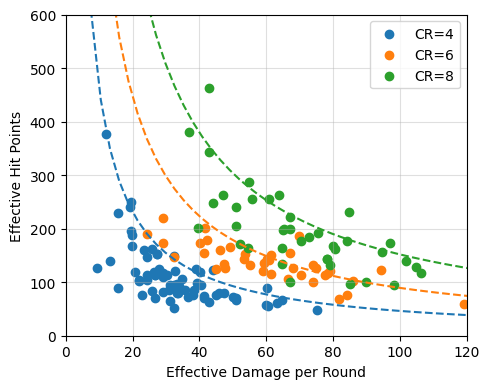

In [ ]:
# DPR vs HP
from matplotlib import pyplot as plt
import numpy as np
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

CRs = [4,6,8]
#colors = ['#1f77b4','#ff7f0e','#2ca02c','#d62728']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = colors[0:3]

fig = plt.figure(figsize=[5,4], dpi=100, tight_layout=True)
ax = plt.axes(xlim=[0,120], ylim=[0,600])

ax.set_xlabel('Effective Damage per Round')
#ax.xaxis.set_major_locator(MultipleLocator(5))
#ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
#ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.set_ylabel('Effective Hit Points')
#ax.yaxis.set_major_locator(MultipleLocator(1.0))
#ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#ax.yaxis.set_minor_locator(MultipleLocator(0.5))

for CR, c in zip(CRs, colors):
    df1 = df0[df0['CR'].isin([CR]) & df0['Category'].isin(['generic','legendary'])]
    ax.scatter(df1['eDPR'], df1['eHP'], label='CR='+str(CR), color=c)

ax.legend()
ax.grid(which='major', axis='both', alpha=0.4)

x = np.linspace(5, 140, 50)
XP = dfD['XP'].values
for CR, c in zip(CRs, colors):
    ax.plot(x, 4*dfD.loc[CR]['eXP Mean']/x, '--', color=c)

In [ ]:
# plot calculated offensive skew vs target CR
#
from matplotlib import pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)

plt.figure()
ax = plt.axes(xlim=[0, 31], ylim=[-1, 1])

ci = 0.75

df1 = df0[df0['CR'].between(1, 30) & df0['Legendary'].isin(['N','L','LL'])]
df1 = df1[['CR','eXP Skew']]

# plot points data
ax.scatter(df1['CR'], df1['eXP Skew'], s=8, color='r')

# plot mean
#dfM = df1.groupby('CR').mean()
#x  = dfM.index.to_series()
#yM = dfM['eXP Skew']
#ax.plot(x, yM, '-', color='r', label='mean')

# plot median
dfM = df1.groupby('CR').quantile(q=0.5, interpolation='linear')
x  = dfM.index.to_series()
yM = dfM['eXP Skew']
ax.plot(x, yM, '-', color='r', label='median')

# plot confidency interfal
dfU = df1.groupby('CR').quantile(q=0.5+ci/2, interpolation='linear')
yU = dfU['eXP Skew']
dfD = df1.groupby('CR').quantile(q=0.5-ci/2, interpolation='linear')
yD = dfD['eXP Skew']
ax.fill_between(x, yD, yU, color='r', alpha=.1, label='75% confidency')

# plot 1-to-1 line
ax.plot(x, x*0.0, '--', color='k')

# add labels
ax.set_xlabel('CR')
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.xaxis.set_minor_locator(MultipleLocator(1))

ax.set_ylabel('Offensive Skew')
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.yaxis.set_minor_locator(MultipleLocator(0.1))

ax.legend()

#plt.savefig('../media/offensive-skew-vs-CR.svg', metadata=METADATA)